In [1]:
import pandas as pd
import numpy as np
from preprocessing import DataProcessor
from utils_cluster import ClusterOptimizer
from utils_cluster import kmeans_cluster_plot, plot_kprototypes_clusters, plot_kmodes_clusters, plot_kmodes_clusters_2D
from sklearn.decomposition import PCA

# Solução

Como criei um arquivo .py para o pré-processamento eu fiz o merge entre as duas bases e apliquei o pré-processamento na base resultante.

Como são apenas 2 variáveis contínuas, numéricas, e o restante é categórica. O dataset de modelagem ficou com uma dimensionalidade muito grande. Para diminuir o impacto da dimensionalidade eu apliquei um PCA.

Peguei as variáveis com um corte de 80% na importâcia cumulativa.

Para escolher o número ótimo de clusters eu testei 3 diferentes aboradagens: teste do elbow, método da silhueta e o BIC.

* O Elbow Test indicou uma estabilização na redução da inércia a partir de 8 a 10 clusters, mas o BIC sugere penalização significativa a partir de 6 clusters, indicando que a complexidade pode ser excessiva com muitos clusters.
* O coeficiente de silhueta aponta que a separação ideal está com poucos clusters, sendo que o valor máximo é para 2 clusters, mas cai rapidamente em seguida, sugerindo que mais clusters podem comprometer a qualidade da separação.
* O BIC também sugere que entre 4 e 5 clusters você pode alcançar um bom equilíbrio entre explicabilidade e simplicidade.

Portanto, 4 a 5 clusters é a melhor quantidade recomendada, considerando a estrutura e as características dos seus dados após a aplicação do PCA.

Após o PCA, as viráveis que ficaram são todas categóricas. Sendo assim, escolhi o K-Modes como modelo.

O K-Modes é um algoritmo de clusterização projetado especificamente para lidar com dados categóricos. É uma adaptação do algoritmo K-Means, que é voltado para dados numéricos, e utiliza medidas de similaridade adequadas a dados categóricos para agrupar elementos com características semelhantes.

Entendo que a parte mais trabalhosa da clusterização é analisar cada um dos clusters para entender se o agrupamento fazs sentido. Isto não foi feito pq dmanda mais tempo.

In [ ]:
# leitura das bases e merge pela coluna name
heroes_information = pd.read_csv("/Users/aurelianosancho/.cache/kagglehub/datasets/claudiodavi/superhero-set/versions/1/heroes_information.csv", index_col=0)
heroes_information = heroes_information.drop_duplicates(subset='name')
super_hero_powers = pd.read_csv("/Users/aurelianosancho/.cache/kagglehub/datasets/claudiodavi/superhero-set/versions/1/super_hero_powers.csv", index_col=0)
super_hero_powers.index.name = 'name'
super_hero_powers.reset_index(inplace=True)
df = heroes_information.merge(super_hero_powers, on='name', how='inner')

In [ ]:
processor = DataProcessor(df)
processor.preprocessing()
processor.normalize_min_max()
cat_heroes_information = ['Gender', 'Eye color', 'Hair color', 'Publisher', 'Alignment']
cat_super_hero_powers = list(super_hero_powers.columns)
cat_super_hero_powers.remove('name')
cat_cols = cat_super_hero_powers + cat_heroes_information
processor.onehot_encode_columns(cat_heroes_information)
model_base = processor.df
# coluna name transformada em index
model_base.set_index('name', inplace=True)
model_base.head(3)


,Height,Weight,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,...,Publisher_Dark Horse Comics,Publisher_George Lucas,Publisher_Marvel Comics,Publisher_Shueisha,Publisher_Star Trek,Publisher_Team Epic TV,Publisher_Unknown,Alignment_bad,Alignment_good,Alignment_neutral
name,,,,,,,,,,,,,,,,,,,,,
Abe Sapien,0.739130,0.237705,True,True,False,False,True,True,False,False,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Abin Sur,0.608696,0.442623,False,False,True,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Absorbing Man,0.782609,0.704918,False,False,False,False,True,True,False,True,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# PCA

O PCA (Principal Component Analysis) é uma técnica de redução de dimensionalidade que transforma um conjunto de variáveis possivelmente correlacionadas em um conjunto menor de variáveis não correlacionadas, chamadas de componentes principais

In [ ]:
print(f"Após as escolhas feitas no pré-processamento a base ficou com apenas {len(model_base.columns)} linhas")

224

In [5]:
df = model_base.copy()

# Aplicar o PCA para reter 95% da variância diretamente nos dados dummies
pca = PCA(n_components=0.95, random_state=42)
data_pca = pca.fit_transform(df)

# Exibir o número de componentes principais escolhidos e a variância explicada
print(f"Number of principal components: {data_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.2f}")

# Criar o DataFrame para os dados transformados pelo PCA
data_pca_df = pd.DataFrame(data_pca, index=df.index, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])

# Obter as cargas do PCA
loadings = pca.components_

# Converter as cargas para um DataFrame para facilitar a interpretação
loadings_df = pd.DataFrame(loadings.T, index=df.columns, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])

importance = loadings_df.abs().mean(axis=1)

# Ordenar as variáveis pela importância média em ordem decrescente
sorted_importance = importance.sort_values(ascending=False)

# Calcular a soma acumulada das importâncias normalizada para ficar em percentual
cumulative_importance = sorted_importance.cumsum() / sorted_importance.sum()

# Definir um corte em 80% da importância acumulada
top_features = cumulative_importance[cumulative_importance <= 0.8].index.tolist()

# Exibir as variáveis selecionadas
top_features

Number of principal components: 95
Explained variance ratio: 0.95


['Animal Oriented Powers',
 'Enhanced Senses',
 'Energy Absorption',
 'Invulnerability',
 'Energy Constructs',
 'Teleportation',
 'Telepathy Resistance',
 'Toxin and Disease Resistance',
 'Size Changing',
 'Time Travel',
 'Jump',
 'Longevity',
 'Natural Weapons',
 'Force Fields',
 'Energy Beams',
 'Stealth',
 'Molecular Manipulation',
 'Weapons Master',
 'Energy Manipulation',
 'Telepathy',
 'Energy Blasts',
 'Peak Human Condition',
 'Hair color_Red',
 'Enhanced Hearing',
 'Wallcrawling',
 'Hair color_Blond',
 'Shapeshifting',
 'Immortality',
 'Self-Sustenance',
 'Psionic Powers',
 'Hair color_White',
 'Power Suit',
 'Danger Sense',
 'Hair color_No Hair',
 'Magic',
 'Levitation',
 'Reflexes',
 'Hair color_Brown',
 'Electrokinesis',
 'Weapon-based Powers',
 'Eye color_green',
 'Super Strength',
 'Accelerated Healing',
 'Fire Control',
 'Marksmanship',
 'Vision - Telescopic',
 'Telekinesis',
 'Phasing',
 'Regeneration',
 'Vision - Night',
 'Agility',
 'Durability',
 'Gender_Male',
 'Eye 

In [6]:
model_base = model_base[top_features]

In [7]:
optimizer = ClusterOptimizer(model_base)

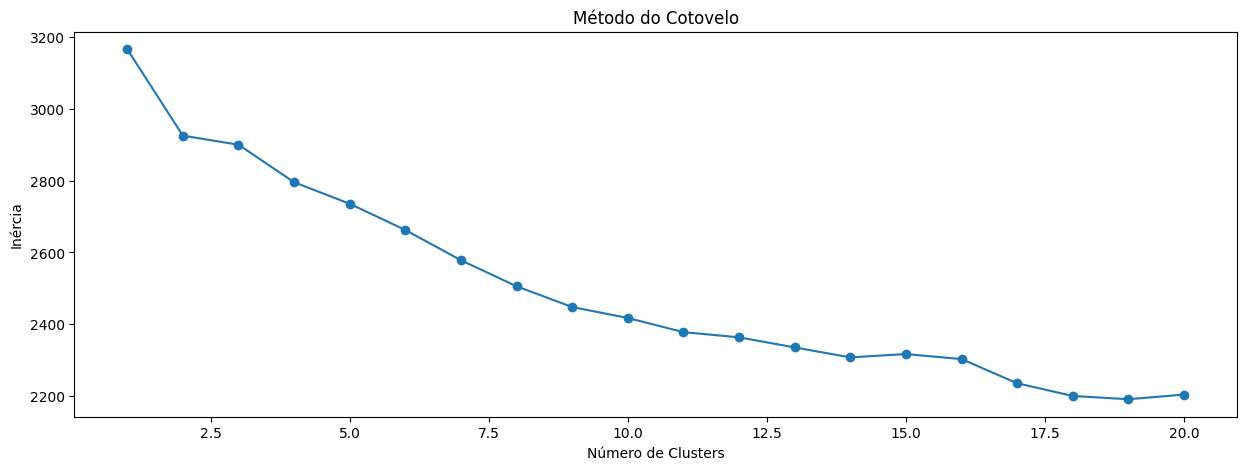

[(1, 3165.5211644856454),
 (2, 2925.034780891715),
 (3, 2899.758766096173),
 (4, 2795.3224723038466),
 (5, 2735.387242801411),
 (6, 2662.4135975265613),
 (7, 2578.1798279892705),
 (8, 2505.770302678443),
 (9, 2447.927698356365),
 (10, 2417.584521723612),
 (11, 2378.134198152473),
 (12, 2363.670245510381),
 (13, 2335.6118653683407),
 (14, 2307.9093955536237),
 (15, 2317.187681251734),
 (16, 2303.0951122941283),
 (17, 2235.8589071541355),
 (18, 2200.4866145185515),
 (19, 2191.4503573575917),
 (20, 2204.415238732715)]

In [8]:
inercia = optimizer.elbow_method(max_clusters=20)
inercia

Baseado nesses resultados, um número entre 8 e 10 clusters parece ser o mais adequado, pois é onde a curva de inércia começa a se estabilizar sem uma queda acentuada adicional.

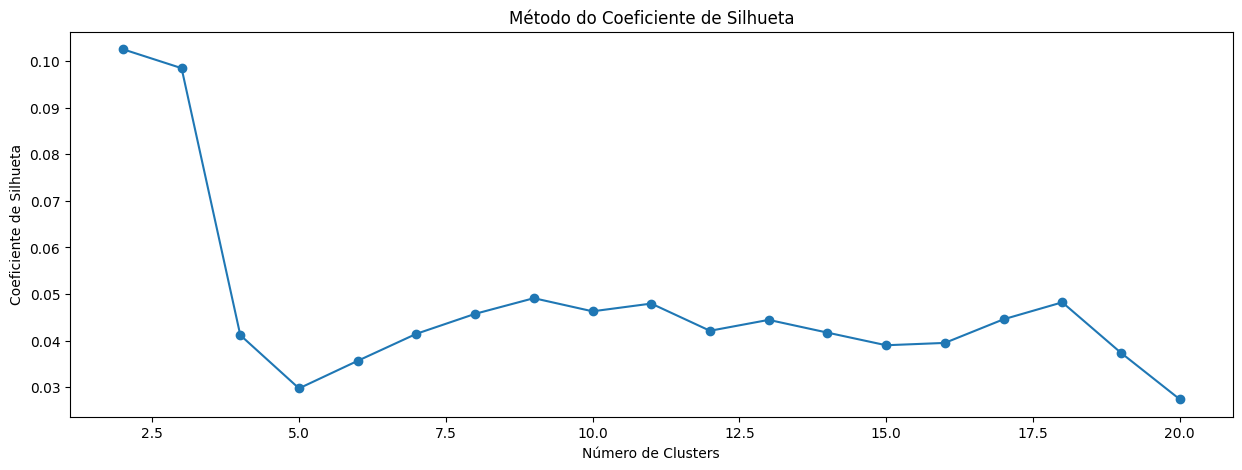

In [9]:
optimizer.silhouette_method(max_clusters=20)

Se o objetivo for maximizar a qualidade da separação (com base no coeficiente de silhueta), 2 clusters parecem ser a melhor opção. No entanto, se 2 clusters forem insuficientes para a análise desejada, uma abordagem intermediária pode ser testar 4 ou 5 clusters, pois esses valores apresentam uma leve estabilidade antes de uma queda acentuada no coeficiente de silhueta.

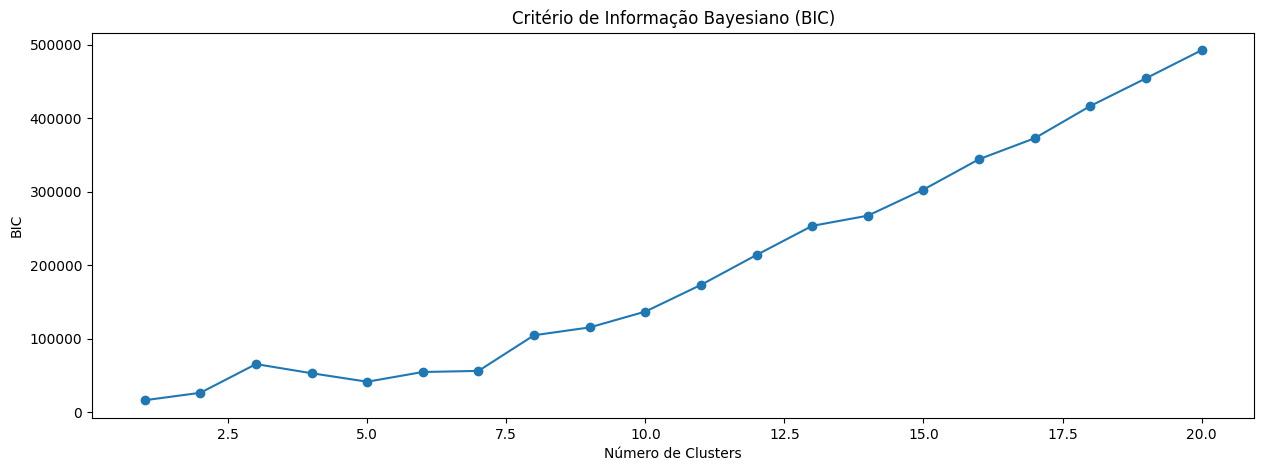

In [10]:
optimizer.bic_gmm_method(max_clusters=20)

Com base no BIC, um número de clusters entre 4 e 5 parece ser o ponto ideal. Esse intervalo é onde o critério de informação penaliza menos o modelo, sugerindo que estamos atingindo um bom equilíbrio entre a simplicidade e a adequação do modelo.

## Justificativa para 4 ou 5 clusters:

* O Elbow Test indicou uma estabilização na redução da inércia a partir de 8 a 10 clusters, mas o BIC sugere penalização significativa a partir de 6 clusters, indicando que a complexidade pode ser excessiva com muitos clusters.
* O coeficiente de silhueta aponta que a separação ideal está com poucos clusters, sendo que o valor máximo é para 2 clusters, mas cai rapidamente em seguida, sugerindo que mais clusters podem comprometer a qualidade da separação.
* O BIC também sugere que entre 4 e 5 clusters você pode alcançar um bom equilíbrio entre explicabilidade e simplicidade.

Portanto, 4 a 5 clusters é a melhor quantidade recomendada, considerando a estrutura e as características dos seus dados após a aplicação do PCA.

# K-Modes

O K-Modes é um algoritmo de clusterização projetado especificamente para lidar com dados categóricos. É uma adaptação do algoritmo K-Means, que é voltado para dados numéricos, e utiliza medidas de similaridade adequadas a dados categóricos para agrupar elementos com características semelhantes.

/Users/aurelianosancho/Dropbox/GitHub/Alelo/utils_cluster.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = clusters
/Users/aurelianosancho/Dropbox/GitHub/Alelo/utils_cluster.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=data, palette='viridis')


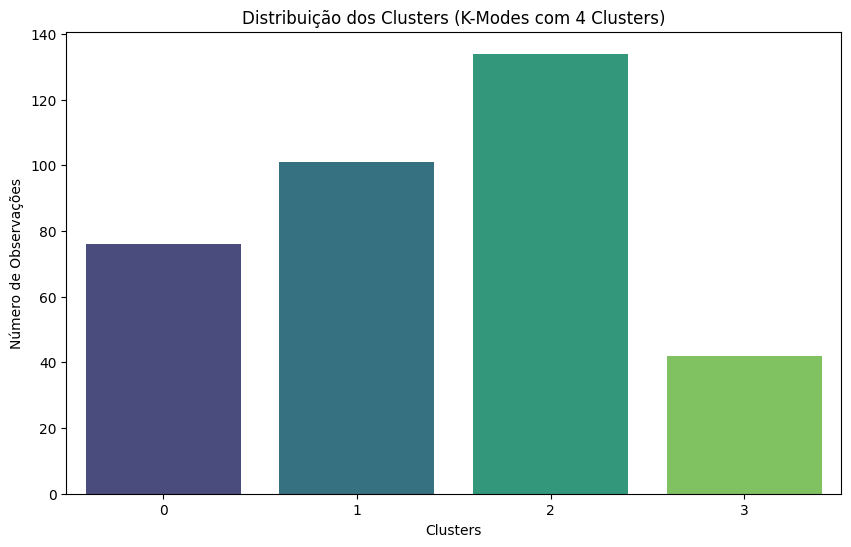

In [20]:
plot_kmodes_clusters(data=model_base, n_clusters = 4)

/Users/aurelianosancho/Dropbox/GitHub/Alelo/utils_cluster.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = clusters


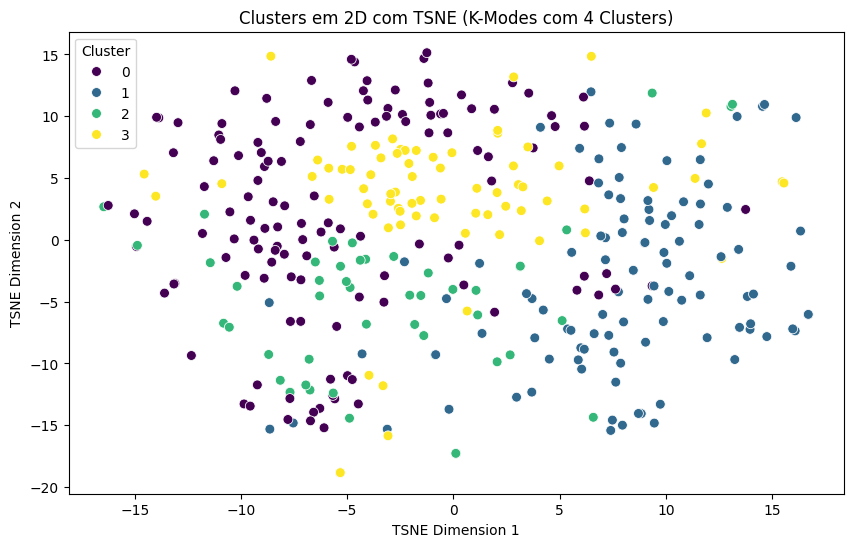

In [21]:
plot_kmodes_clusters_2D(data=model_base, n_clusters = 4, init='Huang', n_init=5)

/Users/aurelianosancho/Dropbox/GitHub/Alelo/utils_cluster.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = clusters


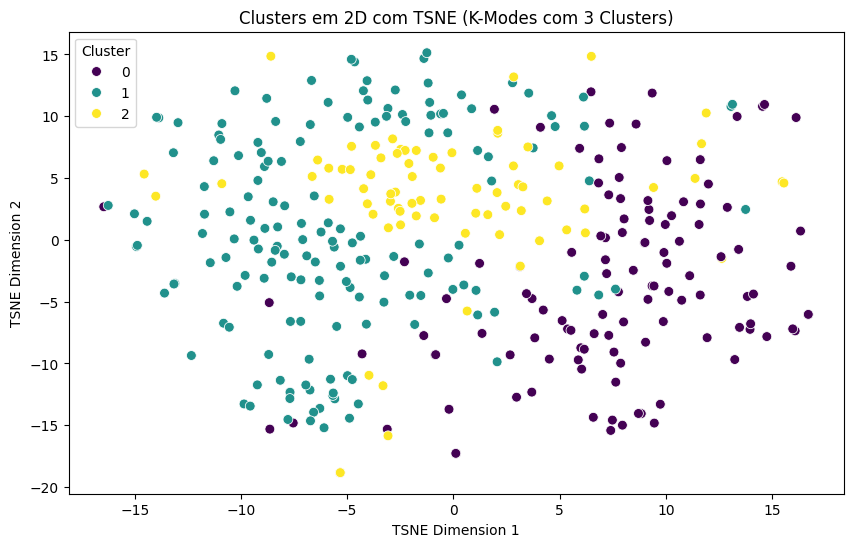

In [22]:
plot_kmodes_clusters_2D(data=model_base, n_clusters = 3, init='Huang', n_init=5)

In [ ]:
# Fim